In [13]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import argparse
from argparse import Namespace

def read_line_number(file_path, line_num):
    with open(file_path, 'r') as fin:
        for i,line in enumerate(fin):
            if i == line_num:
                return line.strip()
    return ""

def extract_args(log_path):
    print(log_path)
    argstr = read_line_number(log_path, 1)
    if 'fair_lambda' not in argstr:
        argstr = argstr[:-1] + ', fair_lambda=0.1)'
    if 'fair_rho' not in argstr:
        argstr = argstr[:-1] + ', fair_rho=1)'
    if 'fair_group_feature' not in argstr:
        argstr = argstr[:-1] + f", fair_group_feature='{group_feature}')"
    args = eval(argstr)
    return args

In [14]:
from reader.BaseReader import worker_init_func
from task.TopK import init_ranking_report, calculate_ranking_metric

def get_userwise_group(model, group_feature, fairness_control):
    eval_data = model.reader.get_eval_dataset()
    eval_loader = DataLoader(eval_data, worker_init_fn = worker_init_func,
                             batch_size = 1, shuffle = False, pin_memory = False, 
                             num_workers = eval_data.n_worker)
    user_groups = {}
    with torch.no_grad():
        for i, batch_data in enumerate(eval_loader):
            # sample user with record in eval data
            if "no_item" not in batch_data:
                # predict
                feed_dict = model.wrap_batch(batch_data)
                uid = feed_dict["user_UserID"].reshape(-1).detach().cpu().numpy()[0]
                user_groups[uid] = fairness_control.group_dict[uid]
    return user_groups

def get_userwise_performance(model, at_k_list):
    model.reader.set_phase('test')
    eval_data = model.reader.get_eval_dataset()
    eval_loader = DataLoader(eval_data, worker_init_fn = worker_init_func,
                             batch_size = 1, shuffle = False, pin_memory = False, 
                             num_workers = eval_data.n_worker)
    user_results = {}
    with torch.no_grad():
        for i, batch_data in enumerate(eval_loader):
            # sample user with record in eval data
            if "no_item" not in batch_data:
                # predict
                feed_dict = model.wrap_batch(batch_data)
                out_dict = model.forward(feed_dict, return_prob = True)
                pos_preds, neg_preds = out_dict["probs"], out_dict["neg_probs"]
                if pos_preds.is_cuda:
                    pos_preds = pos_preds.detach().cpu()
                    neg_preds = neg_preds.detach().cpu()
                # metrics
                report = init_ranking_report(at_k_list)
                calculate_ranking_metric(pos_preds.view(-1), neg_preds.view(-1), at_k_list, report)
                uid = feed_dict["user_UserID"].reshape(-1).detach().cpu().numpy()[0]
                user_results[uid] = report
    return user_results

In [15]:
from reader.RecDataReader import RecDataReader
from model.fair_rec.FairUserGroupPerformance import FairUserGroupPerformance
from model.baselines import *
from model.fed_rec import *
import os
import torch

model_name_list = {'MF': 'MF', 'FedMF': 'FedMF', 'FairMF': 'MF', 'F2MF': 'FedMF'}
device = -1
if device >= 0 and torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = str(device)
    torch.cuda.set_device(device)
    device = "cuda:" + str(device)
else:
    device = "cpu"
params = {'at_k_list': [10,50], 'eval_sample_p': 1.0}

## Do Fairness Evaluation

In [24]:
group_feature = 'activity'
# data_key = 'ml-1m'
data_key = 'amz_Movies_and_TV'
# data_key = 'amz_Books'
ROOT="/home/sl1471/workspace/experiments/"
best_setting = {
    'ml-1m': {
        'MF': [
            '/logs/f2rec_train_and_eval_MF_lr0.0001_reg0.1_losspairwisebpr.log'
        ], 
        'FedMF': [
            '/logs/f2rec_train_and_eval_FedMF_lr0.003_reg0.1_losspairwisebpr_local1_fedavg.log'
        ], 
        'FairMF': [
            '/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.1_gactivity.log'
            ,'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0_gactivity.log'],
        'F2MF': [
#             '/logs/f2rec_train_and_eval_FairFedMF_lr0.0003_reg0.1_losspairwisebpr_lambda-0.1_sigma0_gactivity.log'
        ]
    },
    'amz_Books': {
        'MF': ['/logs/f2rec_train_and_eval_MF_lr0.00001_reg1.0_losspairwisebpr.log'], 
        'FedMF': [],
        'FairMF': [],
        'F2MF': []
    },
    'amz_Movies_and_TV': {
        'MF': [
            '/logs/f2rec_train_and_eval_MF_lr0.00003_reg1.0_losspairwisebpr.log'
        ], 
        'FedMF': [
            '/logs/f2rec_train_and_eval_FedMF_lr0.003_reg1.0_losspairwisebpr_local1_fedavg.log'
        ], 
        'FairMF': [
            '/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.1_gactivity.log'
            ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0_gactivity.log'
            ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.1_gactivity.log'
        ],
        'F2MF': [
#             '/logs/f2rec_train_and_eval_FairFedMF_lr0.0003_reg1.0_losspairwisebpr_lambda-0.1_sigma0_gactivity.log'
#             ,'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg1.0_losspairwisebpr_lambda0_sigma0.3_gactivity.log'
        ]
    }
}

In [ ]:
import os
import datetime
from torch.utils.data import DataLoader
import torch
import numpy as np

metrics = ['F1@10','NDCG@10','F1@50','NDCG@50','AUC']
# for data_key in data_key_list:
result_file_path = ROOT + data_key + "/results/fairness_" + group_feature + "_" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + ".csv"
with open(result_file_path, 'w') as fout:
    count = 0
    for modelName, modelDef in model_name_list.items():
        log_path_list = best_setting[data_key][modelName]
        for log_path in log_path_list:
            # args
            try:
                args = extract_args(ROOT + data_key + log_path)
                print(args)
            except:
                print('skip')
                continue
            # reader
            if count == 0:
                reader = RecDataReader(args)
                # fairness calculator
                args.fair_group_feature = group_feature
                fairness_controller = FairUserGroupPerformance(args, reader)
            # model
            modelClass = eval('{0}.{0}'.format(modelDef))
            model = modelClass(args, reader, device)
            model.load_from_checkpoint(args.model_path, with_optimizer = False)
            model = model.to(device)
            model.device = device
            # header
            if count == 0:
                uG = get_userwise_group(model, group_feature, fairness_controller)
                fout.write('\t'.join(['model','fair_group','fair_lambda','metric'] + [str(uid) for uid in uG.keys()]) + '\n')
                fout.write('\t'.join(['all','-','-','group'] + list(uG.values())) + '\n')
            count += 1
            # evaluation
            user_results = get_userwise_performance(model, params['at_k_list'])
            for m in metrics:
                fout.write('\t'.join([modelName,args.fair_group_feature,str(args.fair_lambda),m] + 
                                     [str(user_results[uid][m]) if uid in user_results else '0' for uid in uG]) + '\n')

/home/sl1471/workspace/experiments/amz_Movies_and_TV/logs/f2rec_train_and_eval_MF_lr0.00003_reg1.0_losspairwisebpr.log
Namespace(cuda=3, seed=19, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/amz_Movies_and_TV/models/f2rec_MF_lr0.00003_reg1.0_pairwisebpr.pkl', loss='pairwisebpr', l2_coef=1.0, emb_size=32, data_file='/home/sl1471/workspace/experiments/amz_Movies_and_TV/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/user_fields.vocab', item_fields_vocab_file='/home/sl147

100%|██████████| 5498/5498 [00:27<00:00, 200.40it/s]


user activity: 1335(A) -- 4163(I), threshold (71.07984721716988)
embedding: tensor([[-0.0531,  0.0071,  0.0251,  ...,  0.0064,  0.0111,  0.0020],
        [ 0.0069,  0.0349,  0.0108,  ...,  0.0102,  0.0196, -0.0172],
        [ 0.0040,  0.0514, -0.0206,  ...,  0.0171,  0.0199,  0.0376],
        ...,
        [-0.0071, -0.0029,  0.0302,  ...,  0.0150,  0.0215, -0.0283],
        [-0.0174, -0.0003, -0.0002,  ..., -0.0127,  0.0173,  0.0276],
        [-0.0195, -0.0424,  0.0297,  ...,  0.0063, -0.0050,  0.0088]])
embedding: tensor([[ 0.0097, -0.0027, -0.0244,  ...,  0.0003,  0.0164,  0.0043],
        [-0.0109,  0.0049, -0.0028,  ...,  0.0285,  0.0175,  0.0070],
        [ 0.0114,  0.0071, -0.0110,  ..., -0.0011,  0.0084,  0.0078],
        ...,
        [ 0.0115, -0.0108, -0.0302,  ..., -0.0117,  0.0297,  0.0041],
        [ 0.0289, -0.0152,  0.0003,  ...,  0.0055,  0.0040,  0.0093],
        [ 0.0091,  0.0064,  0.0085,  ...,  0.0164, -0.0215,  0.0057]])
Load (checkpoint) from /home/sl1471/workspace

100%|██████████| 5497/5497 [15:42<00:00,  5.83it/s]


/home/sl1471/workspace/experiments/amz_Movies_and_TV/logs/f2rec_train_and_eval_FedMF_lr0.003_reg1.0_losspairwisebpr_local1_fedavg.log
Namespace(cuda=3, seed=19, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/amz_Movies_and_TV/models/f2rec_FedMF_lr0.003_reg1.0_pairwisebpr_local1_fedavg.pkl', loss='pairwisebpr', l2_coef=1.0, emb_size=32, device_dropout_p=0.1, device_dropout_type='same', n_local_step=1, random_local_step=False, aggregation_func='fedavg', mitigation_trade_off=1.0, elastic_mu=0.01, data_file='/home/sl1471/workspace/experiments/amz_Movies_and_TV/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiment

100%|██████████| 5497/5497 [15:49<00:00,  5.79it/s]


/home/sl1471/workspace/experiments/amz_Movies_and_TV/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.1_gactivity.log
Namespace(cuda=2, seed=19, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/amz_Movies_and_TV/models/f2rec_FairMF_lr0.00001_reg1.0_pairwisebpr_lambda-0.1_gactivity.pkl', loss='pairwisebpr', l2_coef=1.0, emb_size=32, data_file='/home/sl1471/workspace/experiments/amz_Movies_and_TV/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/user_

 17%|█▋        | 929/5497 [02:46<15:01,  5.07it/s]

In [ ]:
# result_file_path = ROOT + data_key + "/results/fairness_activity_20220113_124929.csv"
with open(result_file_path, 'r') as fin:
    header = fin.readline().strip().split('\t')
    result_dict = {i: [h] for i,h in enumerate(header)}
    for line in fin:
        row = line.strip().split('\t')
        for i,v in enumerate(row):
            result_dict[i].append(v)

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(result_dict,orient='index')
df[:10]

In [ ]:
import numpy as np
groups = np.unique(df[1].values[4:])

In [ ]:
import numpy as np
from tqdm import tqdm
group_metrics = {G: {} for G in groups}
for G in tqdm(groups):
    subset = df.loc[df[1] == G]
    
    for col in range(2,len(df.columns)):
        label = '-'.join([df[col].iloc[i] for i in range(4)])
        group_metrics[G][label] = np.mean([float(v) for v in subset[col].values])
print(group_metrics)

In [ ]:
def get_diff(groupwise_performance, rho = 1):
    S = []
    for i,v0 in enumerate(groupwise_performance):
        for v1 in groupwise_performance[i+1:]:
            S.append(abs(v0-v1) ** rho)
    return np.mean(S)

for label in group_metrics[groups[0]]:
    groupwise_performance = [group_metrics[G][label] for G in groups]
    print(f"{label}\t: {get_diff(groupwise_performance)}\t {groupwise_performance}")

## Plots

In [11]:
def plot_dist(V1, V2):
    n, bins, patches = plt.hist(V1, 50, density=True, alpha=0.7)
    n, bins, patches = plt.hist(V2, 50, density=True, alpha=0.7)
    plt.show()

In [25]:
import numpy as np
from tqdm import tqdm
pick_column = 6
label = '-'.join([df[pick_column].iloc[i] for i in range(4)])
group_metrics = {G: {} for G in groups}
for G in tqdm(groups):
    subset = df.loc[df[1] == G]
    group_metrics[G][label] = [float(v) for v in subset[pick_column].values if float(v) > 0]

100%|██████████| 2/2 [00:00<00:00, 251.61it/s]


/home/sl1471/anaconda3/envs/bmrl/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/sl1471/anaconda3/envs/bmrl/lib/python3.9/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/sl1471/anaconda3/envs/bmrl/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg,

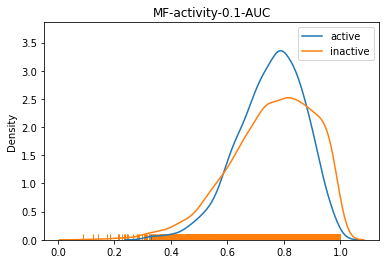

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for G in groups:
    ax = sns.distplot(group_metrics[G][label], rug=True, hist=False, label = G)
#     sns.histplot(data=group_metrics[G][label], x = G, kde=True)
#     plt.hist(group_metrics[G][label], 50, density = True, label = G)
plt.title(label)
plt.legend()
plt.show()